# <center> CSE 4/546: Reinforcement Learning
## Assignment 3 - Actor-Critic
### Part - 3: Solving Complex Environments (Acrobot & BipedalWalker)

<b>Submitted By:</b><br>
Name - Shivansh Gupta<br>
UBIT No - 50604127<br>
UBIT Name - sgupta67<br>
UB Email ID - sgupta67@buffalo.edu<br>

Name - Karan Ramchandani<br>
UBIT No - 50610533<br>
UBIT Name - karamchan<br>
UB Email ID - karamchan@buffalo.edu<br>

#### Importing Required Libraries

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import threading
import pickle
import numpy as np
from torch.distributions import Categorical
from multiprocessing import Manager

### 1) Gym `Acrobot-v1`

#### Creating the required Neural Network for the A2C Model

In [ ]:
# Creating an A2C Neural Network for the forward pass
class Acrobot_A2C_Network(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
        )
        self.actor  = nn.Linear(hidden_dim, act_dim)
        self.critic = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = self.shared(x)
        return self.actor(h), self.critic(h)

#### Creating additional class like Shared adam to help the model take action in a more optimized way

In [3]:
def reset_env(env, device):
    out = env.reset()
    obs = out[0] if isinstance(out, tuple) else out
    obs = np.array(obs, dtype=np.float32)
    return torch.from_numpy(obs).to(device)


def step_env(env, action, device):
    out = env.step(action)
    if len(out) == 5:
        next_obs, reward, term, trunc, _ = out
        done = term or trunc
    else:
        next_obs, reward, done, _ = out
    next_obs = np.array(next_obs, dtype=np.float32)
    return torch.from_numpy(next_obs).to(device), reward, done


# Shared Adam from A3C example so optimizer state lives in shared memory
class SharedAdam(optim.Adam):
    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = torch.zeros(1)
                state['exp_avg'] = torch.zeros_like(p.data)
                state['exp_avg_sq'] = torch.zeros_like(p.data)
                # share in memory
                state['step'].share_memory_()
                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

    def share_memory(self):
        return self


#### Defining the Hyperparameters

In [ ]:
env_name      = "Acrobot-v1"
gamma         = 0.99
lr            = 3e-4
n_steps       = 5
max_episodes  = 10000
hidden_dim    = 128
ent_coef      = 1e-2
vf_coef       = 0.5
max_grad_norm = 0.5
num_workers   = 4

#### Creating a Worker Function to perform A2C Algorithm

In [4]:
def worker(rank, global_model, optimizer, grad_ready,
                  grad_lock, reward_list, device):
    torch.manual_seed(1000 + rank)
    env = gym.make(env_name)
    local_model = ActorCritic(global_model.shared[0].in_features,
                              global_model.actor.out_features,
                              hidden_dim).to(device)
    local_model.load_state_dict(global_model.state_dict())

    episodes_per_worker = max_episodes // num_workers
    for ep in range(1, episodes_per_worker + 1):
        obs = reset_env(env, device)
        total_reward = 0.0
        done = False

        # Keep rolling out n-step segments until the episode ends
        while not done:
            # ← Reset segment buffers
            log_probs, values, rewards, masks, entropies = [], [], [], [], []

            # Collect up to n_steps or until done
            for _ in range(n_steps):
                logits, value = local_model(obs)
                dist = Categorical(logits=logits)
                action = dist.sample()

                next_obs, reward, done = step_env(env, action.item(), device)
                total_reward += reward  # ← accumulate full-episode return

                log_probs.append(dist.log_prob(action))
                values.append(value.squeeze())
                rewards.append(torch.tensor(reward, device=device))
                masks.append(0.0 if done else 1.0)
                entropies.append(dist.entropy())

                obs = next_obs
                if done:
                    break  # episode has ended

            # Bootstrap final value
            with torch.no_grad():
                _, next_value = local_model(obs)
                R = next_value.squeeze()

            # Compute n-step returns & losses for this segment
            returns = []
            for r, m in zip(reversed(rewards), reversed(masks)):
                R = r + gamma * R * m
                returns.insert(0, R)
            returns   = torch.stack(returns)
            values_t  = torch.stack(values)
            logp_t    = torch.stack(log_probs)
            ent_t     = torch.stack(entropies)
            adv       = returns - values_t

            actor_loss   = -(logp_t * adv.detach()).mean()
            critic_loss  = adv.pow(2).mean()
            entropy_loss = -ent_t.mean()
            loss = actor_loss + vf_coef * critic_loss + ent_coef * entropy_loss

            # Backprop on local model & push gradients
            local_model.zero_grad()
            loss.backward()
            grads = [p.grad.clone() for p in local_model.parameters()]

            scaled = [g / num_workers for g in grads]

            with grad_lock:
                # accumulate into global_model.grad
                for p, g in zip(global_model.parameters(), scaled):
                    if p.grad is None:
                        p.grad = g.to(device)
                    else:
                        p.grad += g.to(device)

                # increment the ready counter
                grad_ready.value += 1

                # if this was the last worker to arrive, step & reset
                if grad_ready.value == num_workers:
                    optimizer.step()
                    optimizer.zero_grad()
                    grad_ready.value = 0

            # reload updated parameters before next rollout
            local_model.load_state_dict(global_model.state_dict())

        # ← Episode has terminated: now we have the full-episode return
        if rank == 0 and ep % 50 == 0:
            print(f"Episode {ep}/{episodes_per_worker}  Total Episode Reward: {total_reward:.2f}")
        
        reward_list.append(total_reward)

        # next loop iteration will reset the env automatically
    env.close()

#### Creating a Worker Training Function to perform the training using multithreading over multiple workers

In [8]:
def worker_training():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # create & share global model
    test_obs = gym.make(env_name).observation_space.sample()
    obs_dim  = np.array(test_obs).shape[0]
    act_dim  = gym.make(env_name).action_space.n
    global_model = ActorCritic(obs_dim, act_dim, hidden_dim).to(device)
    global_model.share_memory()

    optimizer = SharedAdam(global_model.parameters(), lr=lr)
    barrier   = mp.Barrier(num_workers)
    grad_queue = mp.Queue()

    manager     = Manager()
    grad_ready  = manager.Value("i", 0)    
    grad_lock   = manager.Lock() 
    reward_list = manager.list()         
    print("====Training Started====")
    processes = []
    for rank in range(num_workers):
        print(f"Worker No. {rank+1} is Started")
        p = mp.Process(
            target=worker,
            args=(rank,
                global_model,
                optimizer,
                grad_ready,
                grad_lock,
                reward_list,
                device)
        )
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    rewards = list(reward_list)
    checkpoint = {
        'state_dict': global_model.state_dict(),
        'rewards':    rewards
    }

    with open('New_Code/Weights/Acrobat_A2C_Weights.pkl', 'wb') as f:
        pickle.dump(checkpoint, f)
    print(f"Saved model + {len(rewards)} episode‑rewards to Acrobat_A2C_Weights.pkl")

    print("====Training complete====")

#### Training the agent and storing the Weights in a pickle file

In [ ]:
mp.set_start_method("spawn") 
worker_training()

#### Loading the rewards of the learned model to plot the trend

In [10]:
model_weights = pickle.load(open('a3_part_2_a2c_acrobot_sgupta67_karamchan.pkl', 'rb'))
rewards = model_weights['rewards']

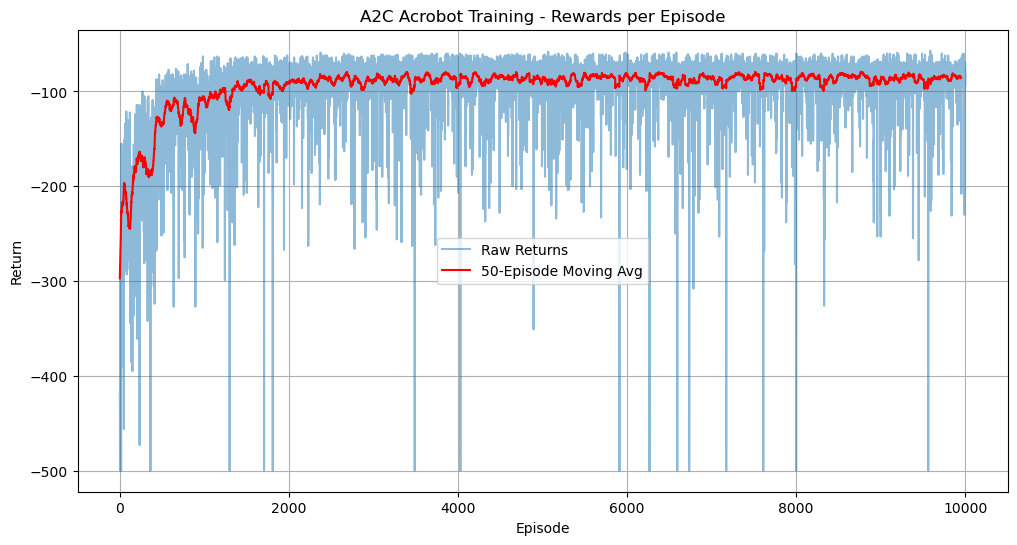

In [15]:
# Plotting the rewards over the episodes as a smoothened trend
plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.5, label='Raw Returns')
smooth_ret = np.convolve(rewards, np.ones(50)/50, mode='valid')
plt.plot(smooth_ret, label='50-Episode Moving Avg', color='red')
plt.title("A2C Acrobot Training - Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()

#### Testing the trained model for 10 Greedy Episodes

In [19]:
test_env = gym.make('Acrobot-v1')
observation_dim = test_env.observation_space.shape[0]
action_dim = test_env.action_space.n
test_env.close()

# Initializing the network
test_model = ActorCritic(observation_dim, action_dim, hidden_dim)

# Loading the trained model weights
checkpoint = pickle.load(open('a3_part_2_a2c_acrobot_sgupta67_karamchan.pkl', 'rb'))
test_model.load_state_dict(checkpoint['state_dict'])
test_model.eval()

greedy_rewards = []

# Testing the trained model for 10 episodes
for ep in range(10):
    state, _ = test_env.reset()
    done = False
    total_reward = 0
    while not done:
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            logit, value = test_model(state_t)
        distributions = torch.distributions.Categorical(logits=logit)
        action_taken = distributions.sample()
        next_state, reward, terminated, truncated, _ = test_env.step(action_taken.item())
        done = truncated or terminated
        total_reward += reward
        state = next_state
        
    print(f"Episode: {ep} Total_reward: {total_reward}")
    greedy_rewards.append(total_reward)
    test_env.close()

Episode: 0 Total_reward: -68.0
Episode: 1 Total_reward: -92.0
Episode: 2 Total_reward: -102.0
Episode: 3 Total_reward: -75.0
Episode: 4 Total_reward: -79.0
Episode: 5 Total_reward: -101.0
Episode: 6 Total_reward: -76.0
Episode: 7 Total_reward: -70.0
Episode: 8 Total_reward: -109.0
Episode: 9 Total_reward: -86.0


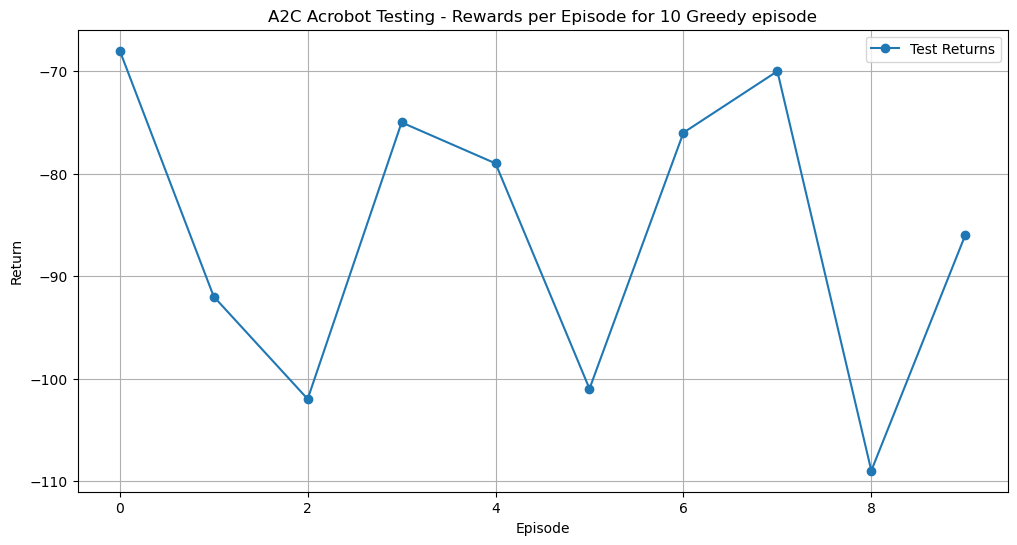

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(greedy_rewards, marker='o', label='Test Returns')
plt.title("A2C Acrobot Testing - Rewards per Episode for 10 Greedy episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()

### 2) Gym `BipedalWalker-v3`

#### Creating the required Neural Network for the A2C Model

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=512):  # Increased hidden size
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden//2)  # Additional layer
        self.mean = nn.Linear(hidden//2, act_dim)
        self.log_std = nn.Parameter(torch.zeros(act_dim) - 1.0)  # Smaller init std
        self.value = nn.Linear(hidden//2, 1)
        
        # Orthogonal initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x  = F.relu(self.fc1(x))
        x  = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))  # Pass through additional layer
        mu = self.mean(x)                  # unconstrained mean
        sd = torch.exp(self.log_std).clamp(min=1e-3)
        v  = self.value(x).squeeze(-1)
        return mu, sd, v

#### Defining the Hyperparameters

In [3]:
ENV = "BipedalWalker-v3"
N_STEPS = 16
GAMMA = 0.99        
ENT_COEF = 0.001
GRAD_CLIP = 0.5     
LR = 5e-5
NUM_WORKERS = 8
NUM_EPS = 1000

#### Creating a Worker Function to perform A2C Algorithm

In [4]:
def worker(wid, shared_model, optimizer, lock,
           env_name, num_eps, n_steps, γ, ent_coef, grad_clip, queue):
    torch.manual_seed(wid)
    env = gym.make(env_name)
    action_low  = torch.from_numpy(env.action_space.low).float()
    action_high = torch.from_numpy(env.action_space.high).float()
    local_model = ActorCritic(env.observation_space.shape[0],
                              env.action_space.shape[0])

    for ep in range(1, num_eps+1):
        state, _ = env.reset()
        done = False
        ep_r = 0.0
        steps_in_episode = 0

        while not done:
            mb_s, mb_a, mb_r, mb_m, mb_logp, mb_v, mb_ent = [],[],[],[],[],[],[]
            local_model.load_state_dict(shared_model.state_dict())

            # Collect experiences
            for _ in range(n_steps):
                s = torch.from_numpy(state).float()
                mu, sd, v = local_model(s.unsqueeze(0))
                dist = torch.distributions.Normal(mu, sd)
                a = dist.sample().squeeze(0)
                a_cl = torch.max(torch.min(a, action_high), action_low)
                logp = dist.log_prob(a).sum()
                entropy = dist.entropy().sum()

                nxt, r, term, trunc, _ = env.step(a_cl.numpy())
                # r = np.clip(r, -10.0, 10.0)
                mask = 0.0 if (term or trunc) else 1.0

                mb_s.append(s)
                mb_a.append(a)
                mb_r.append(r)
                mb_m.append(mask)
                mb_ent.append(entropy)
                mb_logp.append(logp)
                mb_v.append(v.squeeze(0))

                ep_r += r
                state = nxt
                done = term or trunc
                steps_in_episode += 1
                if done: break
                
                if steps_in_episode >= 1000:  # If episode takes too long
                    done = True
                    break

            # Calculate returns and advantages
            if done:
                R = 0.0
            else:
                with torch.no_grad():
                    s = torch.from_numpy(state).float()
                    _, _, v = local_model(s.unsqueeze(0))
                    R = v.item()

            returns = []
            for r, m in zip(reversed(mb_r), reversed(mb_m)):
                R = r + γ * R * m
                returns.insert(0, R)
            
            returns = torch.tensor(returns, dtype=torch.float32)
            mb_v_tensor = torch.stack(mb_v)
            advs = returns - mb_v_tensor.detach()
            
            if advs.numel() > 1 and advs.std() > 1e-8:
                advs = (advs - advs.mean()) / (advs.std() + 1e-8)

            # Calculate losses
            policy_loss = -(torch.stack(mb_logp) * advs.detach()).mean()
            value_loss = F.mse_loss(mb_v_tensor, returns)
            entropy = torch.stack(mb_ent).mean()
            
            loss = policy_loss + 0.5 * value_loss - ent_coef * entropy

            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(local_model.parameters(), grad_clip)
            
            with lock:
                for lp, gp in zip(local_model.parameters(),
                                shared_model.parameters()):
                    if gp.grad is None:
                        gp.grad = lp.grad.clone()
                    else:
                        gp.grad += lp.grad
                optimizer.step()

        # report & enqueue
        if ep % 50 == 0:
            print(f"[Worker {wid}] Ep {ep:3d} Reward: {ep_r:7.1f}")
        queue.put(ep_r)
        state, _ = env.reset()

    env.close()

#### Creating a Worker Training Function to perform the training using multithreading over multiple workers

In [5]:
def worker_training():    
    tmp = gym.make(ENV); 
    od, ad = tmp.observation_space.shape[0], tmp.action_space.shape[0]; tmp.close()
    shared_model = ActorCritic(od, ad)
    shared_model.share_memory()
    optimizer = optim.Adam(shared_model.parameters(), lr=LR)
    lock      = mp.Lock()
    queue     = mp.Queue()

    # spawn
    procs = []
    print("=== Training started ===")
    for wid in range(NUM_WORKERS):
        print(f"Starting worker {wid}")
        p = mp.Process(target=worker, args=(
            wid, shared_model, optimizer, lock,
            ENV, NUM_EPS, N_STEPS, GAMMA,
            ENT_COEF, GRAD_CLIP, queue
        ))
        p.start()
        procs.append(p)

    # collect returns
    total = NUM_WORKERS * NUM_EPS
    returns = [queue.get() for _ in range(total)]
    for p in procs:
        p.join()

    # overall stats
    mean_R = np.mean(returns)
    print(f"\n=== Training complete ===")
    print(f"Mean return over {total} episodes: {mean_R:.2f}")

    checkpoint = {
        'state_dict': shared_model.state_dict(),
        'returns':    returns
    }

    with open('New_Code/Weights/BipeDal_a2c_weights_2.pkl', 'wb') as f:
        pickle.dump(checkpoint, f)
    print("Saved checkpoint ➜ BipeDal_a2c_weights.pkl")

#### Training the agent and storing the Weights in a pickle file

In [ ]:
mp.set_start_method("spawn") 
worker_training()

#### Loading the rewards of the learned model to plot the trend

In [6]:
model_rewards = pickle.load(open('bipedalwalker_a2c_Returns.pkl', 'rb'))

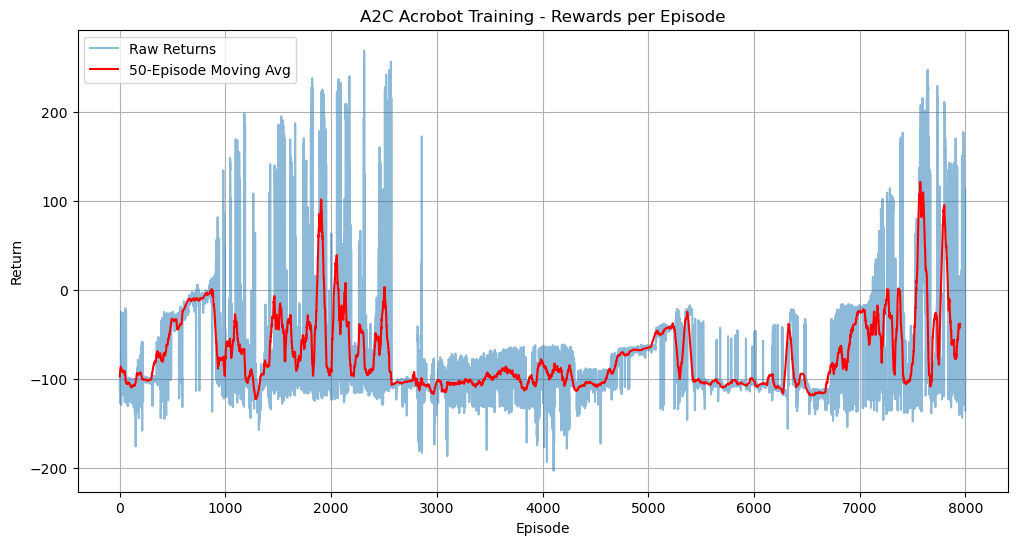

In [7]:
# Plotting the rewards over the episodes as a smoothened trend
plt.figure(figsize=(12, 6))
plt.plot(model_rewards, alpha=0.5, label='Raw Returns')
smooth_ret = np.convolve(model_rewards, np.ones(50)/50, mode='valid')
plt.plot(smooth_ret, label='50-Episode Moving Avg', color='red')
plt.title("A2C Acrobot Training - Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()

#### Testing the trained model for 10 Greedy Episodes

In [ ]:
ckpt = pickle.load(open('bipedalwalker_a2c_weights.pkl','rb'))
ENV = "BipedalWalker-v3"
tmp = gym.make(ENV)
obs_dim = tmp.observation_space.shape[0]
act_dim = tmp.action_space.shape[0]
tmp.close()

model = ActorCritic(obs_dim, act_dim)
model.load_state_dict(ckpt)
model.eval()

greedy_rewards = []

for ep in range(10):
    env = gym.make(ENV)
    s, _ = env.reset()
    done = False
    total_r = 0.0

    while not done:
        with torch.no_grad():
            mu, sd, _ = model(torch.from_numpy(s).float().unsqueeze(0))
        action = mu.squeeze(0).numpy()
        s, r, term, trunc, _ = env.step(action)
        total_r += r
        done = term or trunc
    env.close()
    greedy_rewards.append(total_r)
    print(f"Episode No: {ep+1} | Greedy Rewards: {total_r:.2f}")

Episode No: 1 | Greedy Rewards: 43.85
Episode No: 2 | Greedy Rewards: -100.21
Episode No: 3 | Greedy Rewards: -31.12
Episode No: 4 | Greedy Rewards: -123.53
Episode No: 5 | Greedy Rewards: 233.42
Episode No: 6 | Greedy Rewards: -110.97
Episode No: 7 | Greedy Rewards: -65.41
Episode No: 8 | Greedy Rewards: 198.12
Episode No: 9 | Greedy Rewards: -17.87
Episode No: 10 | Greedy Rewards: -121.31


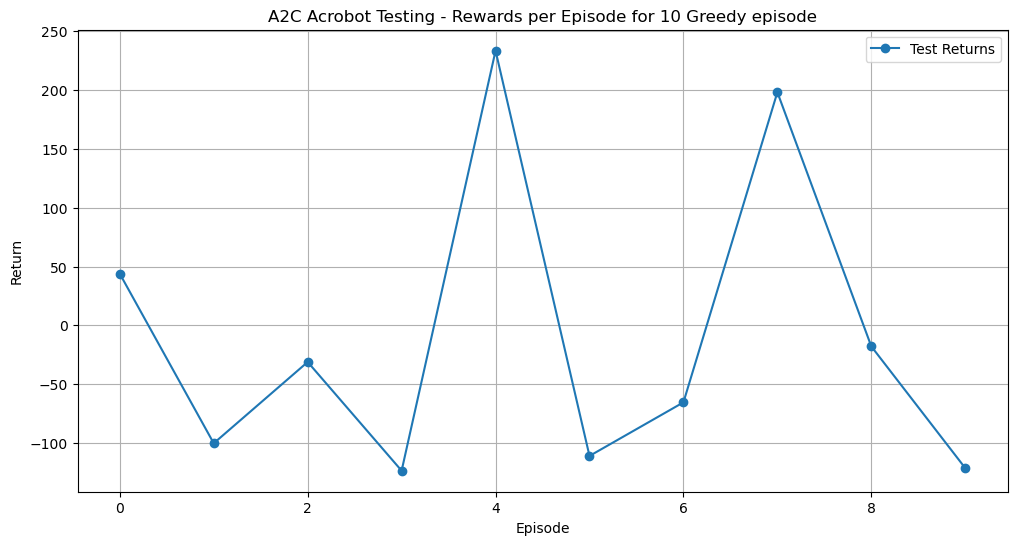

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(greedy_rewards, marker='o', label='Test Returns')
plt.title("A2C Acrobot Testing - Rewards per Episode for 10 Greedy episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()